# Setup
> Make sure that the kernel is  `3.10 - SDK`

In [1]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.16.1
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Connect to the workspace

In [2]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [3]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


# Wait a minute...

Remember the ML workflow ?

# Load the data for experimentation

In [4]:
#from azure.ai.ml import MLClient
import pandas as pd
from azure.identity import DefaultAzureCredential

# If credential is not defined above
#ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("diabetes", version="1")

df = pd.read_csv(data_asset.path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Audit & Explore the data

In [5]:
# get data infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


So no missing values.

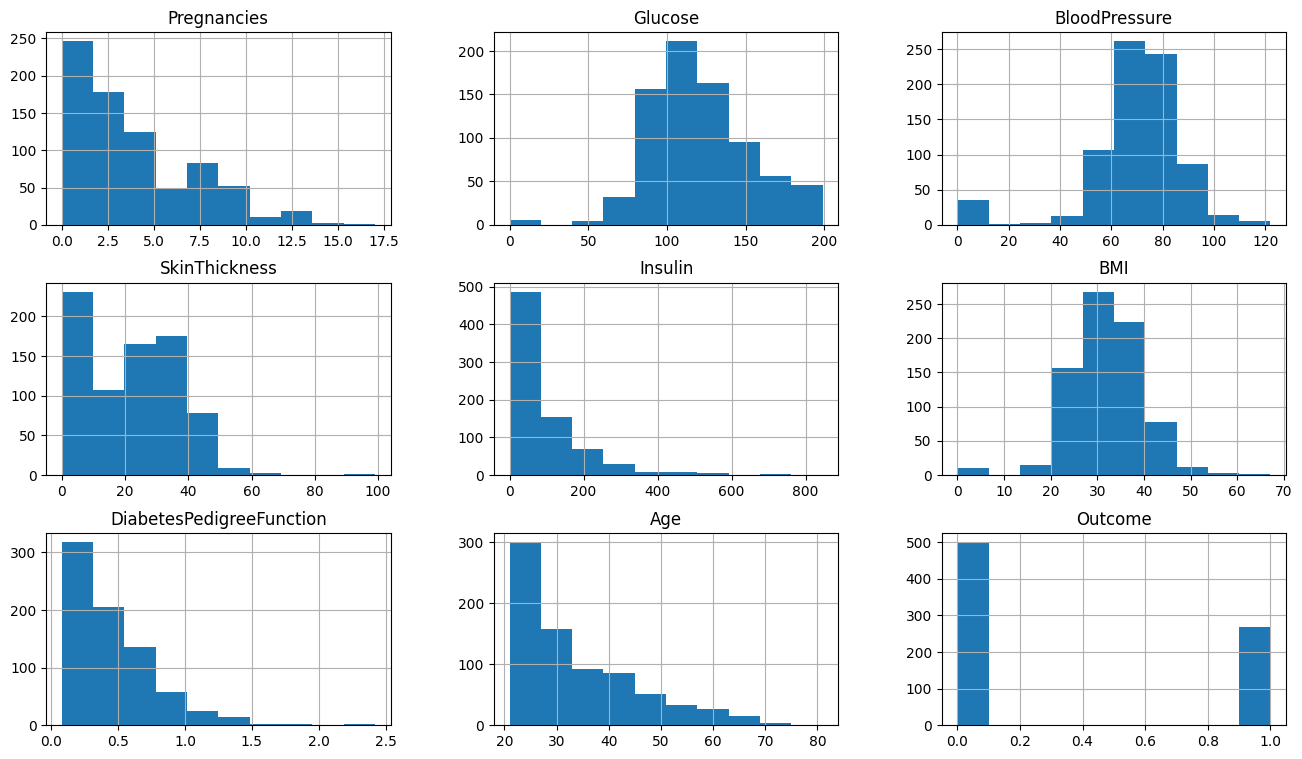

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(figsize=(16, 9));

Few variable might need scaling or normalizing (looking at the distributions). but here let's just say that everything is fine (IT'S NOT!! :wink)

# Train a model baseline

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare the data
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"training accuracy: {model.score(X_train, y_train)}")
print(f"Model accuracy: {accuracy}")

training accuracy: 0.7703583061889251
Model accuracy: 0.7467532467532467


# What do you think about the next steps

1. How do you find these results ? What could you say about it ?
2. What should we do next ?

# Training Pipeline v0

In [ ]:
%%writefile diabetes_training.py
# Import libraries
import argparse
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import mlflow
import mlflow.sklearn

# Parse arguments
parser = argparse.ArgumentParser()
parser.add_argument("--data", type=str, help="Path to input data")
parser.add_argument("--reg_rate", type=float, default=0.01, help="Regularization rate")
parser.add_argument("--registered_model_name", type=str, help="Model name")
args = parser.parse_args()


# Start MLflow run
with mlflow.start_run():

    # Enable autologging
    mlflow.sklearn.autolog()

    # log the regularization rate
    mlflow.log_param("regularization_rate", args.reg_rate)

    # load the diabetes dataset
    print("Loading Data...")
    diabetes = pd.read_csv(args.data)

    # Separate features and labels
    X = diabetes.drop("Outcome", axis=1)
    y = diabetes["Outcome"]

    # Split data into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

    # Train a logistic regression model
    print('Training a logistic regression model with regularization rate of', args.reg_rate)
    model = LogisticRegression(C=1/args.reg_rate, solver="liblinear", max_iter=1000).fit(X_train, y_train)

    # calculate accuracy
    y_hat = model.predict(X_test)
    acc = accuracy_score(y_test, y_hat)
    print('Accuracy:', acc)
    mlflow.log_metric("accuracy", acc)

    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_scores[:,1])
    print('AUC: ' + str(auc))
    mlflow.log_metric("auc", auc)

    # Log the feature names
    mlflow.log_param("features", list(X.columns))

    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=model,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=model,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )

print("Run completed. Model saved with MLflow")

In [ ]:
# Display the contents of the file
!cat diabetes_training.py

What do you think about this script ?

Once again, let's pretend it's fine...

# Training script v2

In [ ]:
%%writefile diabetes_training_v2.py
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

def main():
    """Main function of the script."""

    # Input arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="Path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.30)
    parser.add_argument("--reg_rate", type=float, required=False, default=0.01, help="Regularization rate")
    parser.add_argument("--registered_model_name", type=str, help="Model name")
    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    # Enable autologging
    mlflow.sklearn.autolog()

    ###################
    # <Prepare the data>
    ###################
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))
    print("Input data:", args.data)

    # Load the diabetes dataset
    diabetes = pd.read_csv(args.data)

    mlflow.log_metric("num_samples", diabetes.shape[0])
    mlflow.log_metric("num_features", diabetes.shape[1] - 1)

    # Split data into training set and test set
    train_df, test_df = train_test_split(
        diabetes,
        test_size=args.test_train_ratio,
        random_state=0
    )
    ###################
    # </Prepare the data>
    ###################

    ##################
    # <Train the model>
    ##################
    # Extracting the label column
    y_train = train_df.pop("Outcome")
    X_train = train_df.values

    # Extracting the label column for test set
    y_test = test_df.pop("Outcome")
    X_test = test_df.values

    print(f"Training with data of shape {X_train.shape}")

    # Train a logistic regression model
    model = LogisticRegression(C=1/args.reg_rate, solver="liblinear", max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_hat = model.predict(X_test)
    acc = accuracy_score(y_test, y_hat)
    print('Accuracy:', acc)
    mlflow.log_metric("accuracy", acc)

    # Calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_scores[:, 1])
    print('AUC:', auc)
    mlflow.log_metric("auc", auc)
    ##################
    # </Train the model>
    ##################

    ##########################
    # <Save and register model>
    ##########################
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=model,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=model,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )
    
    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()


In [ ]:
# Display the contents of the file
!cat diabetes_training_v2.py

How could you improve this version ?

# Launching the Script

In [ ]:
# Import the libraries
from azure.ai.ml import MLClient, command, Input
from azure.ai.ml.entities import Environment
from azure.identity import DefaultAzureCredential

# Name the model you registered earlier in the training script
registered_model_name = "diabetes_model"  # Change this to the name you used in your training script

# Get the data asset
data_asset = ml_client.data.get("diabetes", version="1")

# Configure the command job
job = command(
    inputs=dict(
        # uri_file refers to a specific file as a data asset
        data=Input(type="uri_file", path=data_asset.path),
        test_train_ratio=0.30,  # Input variable in main.py
        reg_rate=0.01,  # Input variable in main.py
        registered_model_name=registered_model_name,  # Input variable in main.py
    ),
    code="./",  # Location of source code (where your diabetes_training.py is located)
    # The inputs/outputs are accessible in the command via the ${{ ... }} notation
    command="python diabetes_training_v2.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} --reg_rate ${{inputs.reg_rate}} --registered_model_name ${{inputs.registered_model_name}}",
    # This is the ready-made environment you are using
    environment="azureml://registries/azureml/environments/sklearn-1.5/labels/latest",  # Update to your specific environment if needed
    # This is the compute you created earlier
    compute="vmdemo",  # Change this to your compute target name
    # An experiment is a container for all the iterations one does on a certain project.
    experiment_name="train_model_diabetes_prediction",  # Change this to your desired experiment name
    display_name="diabetes_prediction",  # Change this to your desired display name
)

# Submit the job
try:
    returned_job = ml_client.jobs.create_or_update(job)
    print(f"Job submitted successfully: {returned_job.name}")
    print(f"Monitoring URL: {returned_job.studio_url}")

    # If you want to wait for the job to complete
    ml_client.jobs.stream(returned_job.name)
except Exception as e:
    print(f"An error occurred while submitting the job: {e}")


# Viewing the execution of the job

You can view the result of a training job by clicking the URL generated after submitting a job (above). Alternatively, you can also click Jobs on the left navigation menu. 

A job is a grouping of many runs from a specified script or piece of code. Information for the run is stored under that job.

1. **Overview** is where you can see the status of the job.
2. **Metrics** would display different visualizations of the metrics you specified in the script.
3. **Images **is where you can view any image artifacts that you have logged with MLflow.
4. **Child** jobs contains child jobs if you added them.
5. **Outputs + logs** contains log files you need for troubleshooting or other monitoring purposes.
6. **Code** contains the script/code used in the job.
7. **Explanations and Fairness** are used to see how your model performs against responsible AI standards. They are currently 8. preview features and require additional package installations.
9. **Monitoring** is where you can view metrics for the performance of compute resources.

# How to set a custom environment (using docker)

In [ ]:
environment_yml_content = """
name: sklearn-env
channels:
  - conda-forge
dependencies:
  - python=3.10
  - scikit-learn
  - pandas
  - pip
  - pip:
    - azureml-defaults
    - azureml-core
    - azureml-dataset-runtime
    - azureml-mlflow
    - mlflow
    - joblib
"""

# Write the content to a file
with open("environment.yml", "w") as f:
    f.write(environment_yml_content)

print("environment.yml file has been created in the current directory.")

In [ ]:
# Display the contents of the file
!cat environment.yml

In [ ]:
from azure.ai.ml import MLClient, command, Input, Output
from azure.ai.ml.entities import Environment
from azure.identity import DefaultAzureCredential
import os

# Create a Python environment for the experiment
sklearn_env = Environment(
    conda_file="environment.yml",
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest"
)

# Get the compute target
compute_target = ml_client.compute.get("vmdemo")

# Get the data asset
data_asset = ml_client.data.get("diabetes", version="1")

job = command(
    code="./",  # Local path where the code is stored
    command="python diabetes_training.py --data ${{inputs.data}} --registered_model_name ${{inputs.registered_model_name}}",  # You can pass other parameters as needed
    environment=sklearn_env,
    compute=compute_target.name,
    inputs={
        "data": Input(type="uri_file", path=data_asset.path),
        "registered_model_name": registered_model_name
    }
)

# Submit the job
try:
    returned_job = ml_client.jobs.create_or_update(job)
    print(f"Job submitted successfully: {returned_job.name}")
    print(f"Monitoring URL: {returned_job.studio_url}")

    # If you want to wait for the job to complete
    ml_client.jobs.stream(returned_job.name)
except Exception as e:
    print(f"An error occurred while submitting the job: {e}")


# Deploying your model

See the section 7 in in this [notebook](https://github.com/Azure/azureml-examples/blob/main/tutorials/azureml-getting-started/azureml-getting-started-studio.ipynb)

You have to use the minimum VM requirement : `Standard_D2as_v4`


# Consuming the model

You can test from the interface using the data :

```json
{
  "input_data": {
    "columns": [0,1,2,3,4,5,6,7],
    "index": [0],
    "data": [
            [6, 148, 72, 35, 0, 33.6, 0.627, 70]
        ]
  }
}
```

In [5]:
# consume with code
endpoint = 'https://demo-azure-ml-cwlgd.westus.inference.ml.azure.com/score' #Replace with your endpoint
key = '' #Replace with your key

import json
import requests

#Features for a patient
input_data = {
  "input_data": {
    "columns": [0,1,2,3,4,5,6,7],
    "index": [0],
    "data": [
            [6, 148, 72, 35, 0, 33.6, 0.627, 70]
        ]
  }
}

#Create a "data" JSON object
input_json = json.dumps(input_data)

#Set the content type and authentication for the request
headers = {"Content-Type":"application/json",
           "Authorization":"Bearer " + key}

#Send the request
response = requests.post(endpoint, input_json, headers=headers)

#If we got a valid response, display the predictions
if response.status_code == 200:
    y = response.json()
    #Get the first prediction in the results
    print("Prediction:", y)
else:
    print(response)

Prediction: [1]


With the code provided from the interface.

In [6]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
data =  {
  "input_data": {
    "columns": [0,1,2,3,4,5,6,7],
    "index": [0],
    "data": [
            [6, 148, 72, 35, 0, 33.6, 0.627, 70]
        ]
  },
  "params": {}
}

body = str.encode(json.dumps(data))

url = 'https://demo-azure-ml-cwlgd.westus.inference.ml.azure.com/score'
# Replace this with the primary/secondary key, AMLToken, or Microsoft Entra ID token for the endpoint
api_key = ''
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'diabetes-model-1' }

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'[1]'
